In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/creditcard.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split
x = data.drop(columns='Class', axis=1)
y = data['Class']
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, stratify=y, shuffle=True, random_state=10)

In [4]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, recall_score, precision_score ,average_precision_score, precision_recall_curve, f1_score

실험 시나리오 1 - xgboost

In [5]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=100, learning_rate=0.2, max_depth=4, random_state=32)
model.fit(train_x, train_y)

XGBClassifier(learning_rate=0.2, max_depth=4, random_state=32)

In [6]:
pred = model.predict(test_x)
print (classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.96      0.80      0.88       123

    accuracy                           1.00     71202
   macro avg       0.98      0.90      0.94     71202
weighted avg       1.00      1.00      1.00     71202



In [7]:
precision_recall= average_precision_score(test_y, pred)
precision = precision_score(test_y, pred)
recall = recall_score(test_y, pred)
auc  = roc_auc_score(test_y, pred)
f1 = f1_score(test_y, pred)

print('AUC: ', auc)
print('Precision: ', precision)
print('Recall: ', recall)
print('Precision-Recall: ', precision_recall)
print('F1-score: ', f1)

AUC:  0.9024108866843111
Precision:  0.9611650485436893
Recall:  0.8048780487804879
Precision-Recall:  0.7739577180112974
F1-score:  0.8761061946902655


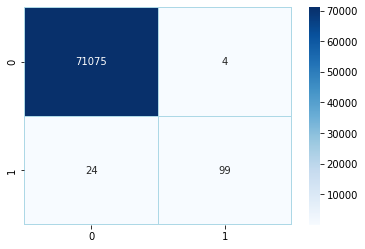

In [8]:
cf_matrix = confusion_matrix(test_y, pred)
sns.heatmap(cf_matrix, annot=True, linewidths=0.1, cmap="Blues", fmt='d', linecolor='lightblue')

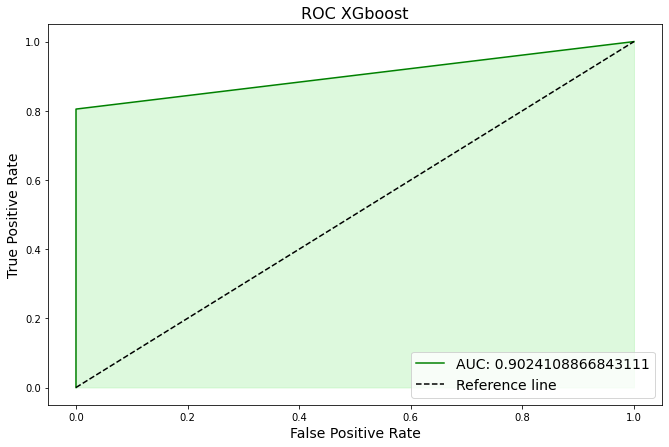

In [9]:
roc_auc_xgboost = np.mean(auc)
fpr_xgboost, tpr_xgboost, thresholds_xgboost = roc_curve(test_y, pred)

# plot 
plt.figure(figsize=(11,7))
plt.plot(fpr_xgboost, tpr_xgboost, color='green', label='AUC: {}'.format(roc_auc_xgboost))
plt.fill_between(fpr_xgboost, tpr_xgboost, color='lightgreen', alpha=0.3)
plt.plot([0,1], [0,1], color='black', ls='--', label='Reference line')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC XGboost', fontsize=16)
plt.legend(loc=4, fontsize=14)
plt.grid(False)
plt.show()

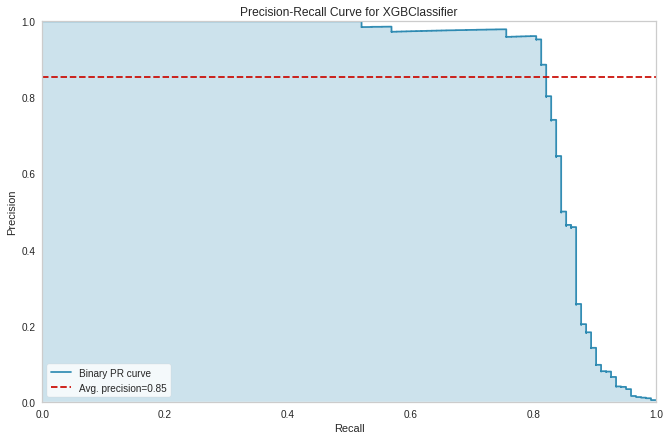

In [46]:
from yellowbrick.classifier import PrecisionRecallCurve, ConfusionMatrix
# Precision-Recall 
# yellowbrick 이용
plt.figure(figsize=(11,7))
plt.title('Precision-Recall XGboost')
plt.xlabel('Recall')
plt.ylabel('Precision')
prcur = PrecisionRecallCurve(model)
prcur.fit(train_x, train_y)
prcur.score(test_x, test_y)
prcur.show()

실험 시나리오 2 - 다른 모델들과 비교 (Logistic Regression, KNN, RandomForest, MLP)

1. Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
lr = LogisticRegression(random_state=32)
lr.fit(train_x, train_y)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=32)

In [14]:
pred = lr.predict(test_x)
print (classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.72      0.70      0.71       123

    accuracy                           1.00     71202
   macro avg       0.86      0.85      0.85     71202
weighted avg       1.00      1.00      1.00     71202



In [15]:
precision_recall= average_precision_score(test_y, pred)
precision = precision_score(test_y, pred)
recall = recall_score(test_y, pred)
auc  = roc_auc_score(test_y, pred)
f1 = f1_score(test_y, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1))

AUC:  0.8493543254345303
Precision:  0.7166666666666667
Recall:  0.6991869918699187
Precision-Recall:  0.5016036591645937
F1-score:  0.7078189300411523


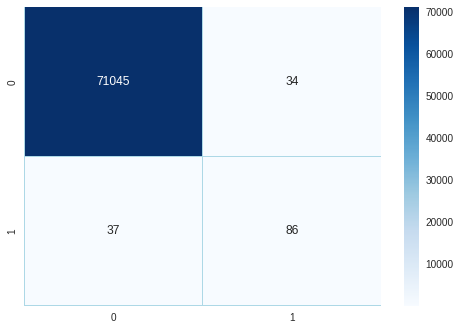

In [16]:
cf_matrix = confusion_matrix(test_y, pred)
sns.heatmap(cf_matrix, annot=True, linewidths=0.1, cmap="Blues", fmt='d', linecolor='lightblue')

2. KNN (n_neighbors = 3) 

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_x, train_y)

KNeighborsClassifier(n_neighbors=3)

In [19]:
pred = knn.predict(test_x)
print (classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.88      0.06      0.11       123

    accuracy                           1.00     71202
   macro avg       0.94      0.53      0.55     71202
weighted avg       1.00      1.00      1.00     71202



In [20]:
precision_recall= average_precision_score(test_y, pred)
precision = precision_score(test_y, pred)
recall = recall_score(test_y, pred)
auc  = roc_auc_score(test_y, pred)
f1 = f1_score(test_y, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1))

AUC:  0.5284482501263623
Precision:  0.875
Recall:  0.056910569105691054
Precision-Recall:  0.05142591568748754
F1-score:  0.10687022900763359


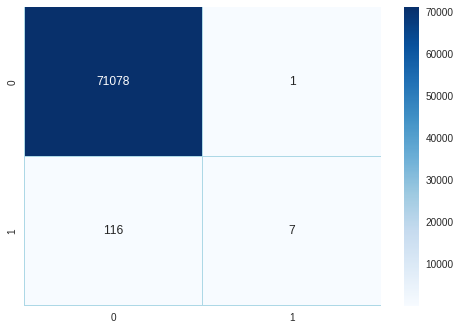

In [21]:
cf_matrix = confusion_matrix(test_y, pred)
sns.heatmap(cf_matrix, annot=True, linewidths=0.1, cmap="Blues", fmt='d', linecolor='lightblue')

3. Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=32)
rfc.fit(train_x, train_y)

RandomForestClassifier(random_state=32)

In [23]:
pred = rfc.predict(test_x)
print (classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.97      0.76      0.85       123

    accuracy                           1.00     71202
   macro avg       0.98      0.88      0.93     71202
weighted avg       1.00      1.00      1.00     71202



In [24]:
precision_recall= average_precision_score(test_y, pred)
precision = precision_score(test_y, pred)
recall = recall_score(test_y, pred)
auc  = roc_auc_score(test_y, pred)
f1 = f1_score(test_y, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1))

AUC:  0.8820927178587616
Precision:  0.9690721649484536
Recall:  0.7642276422764228
Precision-Recall:  0.7409990277442674
F1-score:  0.8545454545454546


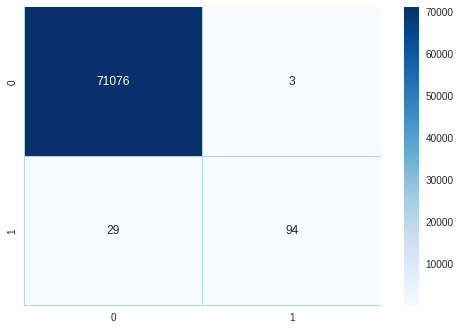

In [25]:
cf_matrix = confusion_matrix(test_y, pred)
sns.heatmap(cf_matrix, annot=True, linewidths=0.1, cmap="Blues", fmt='d', linecolor='lightblue')

4. Neural Network (MLP)

In [36]:
from sklearn.neural_network import MLPClassifier

In [37]:
mlp = MLPClassifier()
mlp.fit(train_x, train_y)

MLPClassifier()

In [38]:
pred = mlp.predict(test_x)
print (classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.55      0.80      0.65       123

    accuracy                           1.00     71202
   macro avg       0.77      0.90      0.83     71202
weighted avg       1.00      1.00      1.00     71202



In [39]:
precision_recall= average_precision_score(test_y, pred)
precision = precision_score(test_y, pred)
recall = recall_score(test_y, pred)
auc  = roc_auc_score(test_y, pred)
f1 = f1_score(test_y, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1))

AUC:  0.9018622014186207
Precision:  0.5469613259668509
Recall:  0.8048780487804879
Precision-Recall:  0.44057423398603723
F1-score:  0.6513157894736843


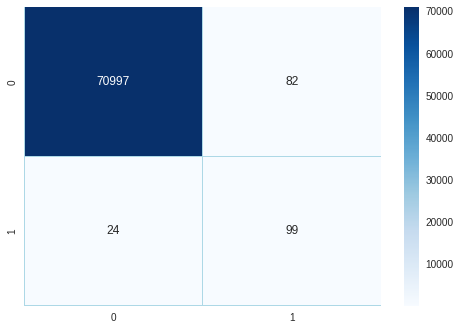

In [40]:
cf_matrix = confusion_matrix(test_y, pred)
sns.heatmap(cf_matrix, annot=True, linewidths=0.1, cmap="Blues", fmt='d', linecolor='lightblue')

* Oversampling(SMOTE) 적용한 xgboost

In [31]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
train_x_over, train_y_over = smote.fit_resample(train_x, train_y)
print('Distribution of training set after applying SMOTE :\n',pd.Series(train_y_over).value_counts() )

Distribution of training set after applying SMOTE :
 0    213236
1    213236
Name: Class, dtype: int64


In [32]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(train_x_over, train_y_over)

XGBClassifier()

In [33]:
pred = xgb.predict(test_x)
print (classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71079
           1       0.22      0.88      0.35       123

    accuracy                           0.99     71202
   macro avg       0.61      0.94      0.67     71202
weighted avg       1.00      0.99      1.00     71202



In [34]:
precision_recall= average_precision_score(test_y, pred)
precision = precision_score(test_y, pred)
recall = recall_score(test_y, pred)
auc  = roc_auc_score(test_y, pred)
f1 = f1_score(test_y, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1))

AUC:  0.9363231704743503
Precision:  0.21951219512195122
Recall:  0.8780487804878049
Precision-Recall:  0.19295308346868653
F1-score:  0.35121951219512193


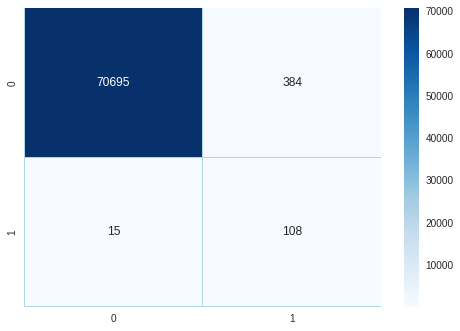

In [35]:
cf_matrix = confusion_matrix(test_y, pred)
sns.heatmap(cf_matrix, annot=True, linewidths=0.1, cmap="Blues", fmt='d', linecolor='lightblue')

실험 시나리오 3 - test set의 base rate를 변경하여 실험

In [ ]:
# test dataset Class 0, 1 나누기
test_x['Class'] = test_y

index2 = test_x.index[test_x.Class == 0]
test_1 = test_x.drop(index2, axis=0)
index1 = test_x.index[test_x.Class == 1]
test_0 = test_x.drop(index1, axis=0)

print(test_0.shape)
print(test_1.shape)

(71079, 31)
(123, 31)


In [ ]:
# base rate 1:1인 test set
test_0_br_1 = test_0.sample(n=len(test_1))
test_br1 = pd.concat([test_0_br_1, test_1])
test_br1 = test_br1.sample(frac=1)
X_test_br1 = test_br1.drop('Class', axis=1)
y_test_br1 = test_br1['Class']

# base rate 1:10인 test set
test_0_br_10 = test_0.sample(n=len(test_1)*10)
test_br10 = pd.concat([test_0_br_10, test_1])
test_br10 = test_br10.sample(frac=1)
X_test_br10 = test_br10.drop('Class', axis=1)
y_test_br10 = test_br10['Class']

# base rate 1:100인 test set
test_0_br_100 = test_0.sample(n=len(test_1)*100)
test_br100 = pd.concat([test_0_br_100, test_1])
test_br100 = test_br100.sample(frac=1)
X_test_br100 = test_br100.drop('Class', axis=1)
y_test_br100 = test_br100['Class']

# base rate 1:577.87인 test set (원본)
X_test_brreal = test_x.drop('Class', axis=1)
y_test_brreal = test_x['Class']

In [ ]:
print(X_test_br1.shape, y_test_br1.shape)
print(X_test_br10.shape, y_test_br10.shape)
print(X_test_br100.shape, y_test_br100.shape)
print(X_test_brreal.shape, y_test_brreal.shape)

(246, 30) (246,)
(1353, 30) (1353,)
(12423, 30) (12423,)
(71202, 30) (71202,)


1. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=32)
lr.fit(train_x, train_y)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=32)

In [ ]:
# base rate = 1:1
pred = lr.predict(X_test_br1)
print (classification_report(y_test_br1, pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87       123
           1       1.00      0.69      0.82       123

    accuracy                           0.85       246
   macro avg       0.88      0.85      0.84       246
weighted avg       0.88      0.85      0.84       246



In [ ]:
precision_recall= average_precision_score(y_test_br1, pred)
precision_lr_br1 = precision_score(y_test_br1, pred)
recall = recall_score(y_test_br1, pred)
auc  = roc_auc_score(y_test_br1, pred)
f1_lr_br1 = f1_score(y_test_br1, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_lr_br1))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_lr_br1))

AUC:  0.8455284552845528
Precision:  1.0
Recall:  0.6910569105691057
Precision-Recall:  0.8455284552845528
F1-score:  0.8173076923076924


In [ ]:
# base rate = 1:10
pred = lr.predict(X_test_br10)
print (classification_report(y_test_br10, pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1230
           1       1.00      0.69      0.82       123

    accuracy                           0.97      1353
   macro avg       0.99      0.85      0.90      1353
weighted avg       0.97      0.97      0.97      1353



In [ ]:
precision_recall= average_precision_score(y_test_br10, pred)
precision_lr_br10 = precision_score(y_test_br10, pred)
recall = recall_score(y_test_br10, pred)
auc  = roc_auc_score(y_test_br10, pred)
f1_lr_br10 = f1_score(y_test_br10, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_lr_br10))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_lr_br10))

AUC:  0.8455284552845528
Precision:  1.0
Recall:  0.6910569105691057
Precision-Recall:  0.7191426459719142
F1-score:  0.8173076923076924


In [ ]:
# base rate = 1:100
pred = lr.predict(X_test_br100)
print (classification_report(y_test_br100, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12300
           1       0.93      0.69      0.79       123

    accuracy                           1.00     12423
   macro avg       0.97      0.85      0.90     12423
weighted avg       1.00      1.00      1.00     12423



In [ ]:
precision_recall= average_precision_score(y_test_br100, pred)
precision_lr_br100 = precision_score(y_test_br100, pred)
recall = recall_score(y_test_br100, pred)
auc  = roc_auc_score(y_test_br100, pred)
f1_lr_br100 = f1_score(y_test_br100, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_lr_br100))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_lr_br100))

AUC:  0.8452845528455284
Precision:  0.9340659340659341
Recall:  0.6910569105691057
Precision-Recall:  0.6485515611330632
F1-score:  0.794392523364486


In [ ]:
# base rate = 1:577.87
pred = lr.predict(X_test_brreal)
print (classification_report(y_test_brreal, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.71      0.69      0.70       123

    accuracy                           1.00     71202
   macro avg       0.86      0.85      0.85     71202
weighted avg       1.00      1.00      1.00     71202



In [ ]:
precision_recall= average_precision_score(y_test_brreal, pred)
precision_lr_brreal = precision_score(y_test_brreal, pred)
recall = recall_score(y_test_brreal, pred)
auc  = roc_auc_score(y_test_brreal, pred)
f1_lr_brreal = f1_score(y_test_brreal, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_lr_brreal))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_lr_brreal))

AUC:  0.8452892847841237
Precision:  0.7142857142857143
Recall:  0.6910569105691057
Precision-Recall:  0.4941457718517283
F1-score:  0.7024793388429752


2. MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(train_x, train_y)

MLPClassifier()

In [ ]:
# base rate = 1:1
pred = mlp.predict(X_test_br1)
print (classification_report(y_test_br1, pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       123
           1       1.00      0.80      0.89       123

    accuracy                           0.90       246
   macro avg       0.92      0.90      0.90       246
weighted avg       0.92      0.90      0.90       246



In [ ]:
precision_recall= average_precision_score(y_test_br1, pred)
precision_mlp_br1 = precision_score(y_test_br1, pred)
recall = recall_score(y_test_br1, pred)
auc  = roc_auc_score(y_test_br1, pred)
f1_mlp_br1 = f1_score(y_test_br1, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_mlp_br1))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_mlp_br1))

AUC:  0.8983739837398375
Precision:  1.0
Recall:  0.7967479674796748
Precision-Recall:  0.8983739837398375
F1-score:  0.8868778280542986


In [ ]:
# base rate = 1:10
pred = mlp.predict(X_test_br10)
print (classification_report(y_test_br10, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1230
           1       1.00      0.80      0.89       123

    accuracy                           0.98      1353
   macro avg       0.99      0.90      0.94      1353
weighted avg       0.98      0.98      0.98      1353



In [ ]:
precision_recall= average_precision_score(y_test_br10, pred)
precision_mlp_br10 = precision_score(y_test_br10, pred)
recall = recall_score(y_test_br10, pred)
auc  = roc_auc_score(y_test_br10, pred)
f1_mlp_br10 = f1_score(y_test_br10, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_mlp_br10))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_mlp_br10))

AUC:  0.8983739837398375
Precision:  1.0
Recall:  0.7967479674796748
Precision-Recall:  0.8152254249815225
F1-score:  0.8868778280542986


In [ ]:
# base rate = 1:100
pred = mlp.predict(X_test_br100)
print (classification_report(y_test_br100, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12300
           1       0.88      0.80      0.83       123

    accuracy                           1.00     12423
   macro avg       0.94      0.90      0.92     12423
weighted avg       1.00      1.00      1.00     12423



In [ ]:
precision_recall= average_precision_score(y_test_br100, pred)
precision_mlp_br100 = precision_score(y_test_br100, pred)
recall = recall_score(y_test_br100, pred)
auc  = roc_auc_score(y_test_br100, pred)
f1_mlp_br100 = f1_score(y_test_br100, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_mlp_br100))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_mlp_br100))

AUC:  0.8978048780487806
Precision:  0.875
Recall:  0.7967479674796748
Precision-Recall:  0.6991668679063028
F1-score:  0.8340425531914893


In [ ]:
# base rate = 1:577.87
pred = mlp.predict(X_test_brreal)
print (classification_report(y_test_brreal, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.55      0.80      0.65       123

    accuracy                           1.00     71202
   macro avg       0.77      0.90      0.82     71202
weighted avg       1.00      1.00      1.00     71202



In [ ]:
precision_recall= average_precision_score(y_test_brreal, pred)
precision_mlp_brreal = precision_score(y_test_brreal, pred)
recall = recall_score(y_test_brreal, pred)
auc  = roc_auc_score(y_test_brreal, pred)
f1_mlp_brreal = f1_score(y_test_brreal, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_mlp_brreal))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_mlp_brreal))

AUC:  0.8978041951946976
Precision:  0.547486033519553
Recall:  0.7967479674796748
Precision-Recall:  0.4365594981629733
F1-score:  0.6490066225165562


3. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=32)
rfc.fit(train_x, train_y)

RandomForestClassifier(random_state=32)

In [ ]:
# base rate = 1:1
pred = rfc.predict(X_test_br1)
print (classification_report(y_test_br1, pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       123
           1       1.00      0.76      0.87       123

    accuracy                           0.88       246
   macro avg       0.90      0.88      0.88       246
weighted avg       0.90      0.88      0.88       246



In [ ]:
precision_recall= average_precision_score(y_test_br1, pred)
precision_rf_br1 = precision_score(y_test_br1, pred)
recall = recall_score(y_test_br1, pred)
auc  = roc_auc_score(y_test_br1, pred)
f1_rf_br1 = f1_score(y_test_br1, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_rf_br1))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_rf_br1))

AUC:  0.8821138211382114
Precision:  1.0
Recall:  0.7642276422764228
Precision-Recall:  0.8821138211382114
F1-score:  0.8663594470046084


In [ ]:
# base rate = 1:10
pred = rfc.predict(X_test_br10)
print (classification_report(y_test_br10, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1230
           1       1.00      0.76      0.87       123

    accuracy                           0.98      1353
   macro avg       0.99      0.88      0.93      1353
weighted avg       0.98      0.98      0.98      1353



In [ ]:
precision_recall= average_precision_score(y_test_br10, pred)
precision_rf_br10 = precision_score(y_test_br10, pred)
recall = recall_score(y_test_br10, pred)
auc  = roc_auc_score(y_test_br10, pred)
f1_rf_br10 = f1_score(y_test_br10, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_rf_br10))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_rf_br10))

AUC:  0.8821138211382114
Precision:  1.0
Recall:  0.7642276422764228
Precision-Recall:  0.7856614929785662
F1-score:  0.8663594470046084


In [ ]:
# base rate = 1:100
pred = rfc.predict(X_test_br100)
print (classification_report(y_test_br100, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12300
           1       0.99      0.76      0.86       123

    accuracy                           1.00     12423
   macro avg       0.99      0.88      0.93     12423
weighted avg       1.00      1.00      1.00     12423



In [ ]:
precision_recall= average_precision_score(y_test_br100, pred)
precision_rf_br100 = precision_score(y_test_br100, pred)
recall = recall_score(y_test_br100, pred)
auc  = roc_auc_score(y_test_br100, pred)
f1_rf_br100 = f1_score(y_test_br100, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_rf_br100))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_rf_br100))

AUC:  0.8820731707317072
Precision:  0.9894736842105263
Recall:  0.7642276422764228
Precision-Recall:  0.7585175205582176
F1-score:  0.8623853211009175


In [ ]:
# base rate = 1:577.87
pred = rfc.predict(X_test_brreal)
print (classification_report(y_test_brreal, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.97      0.76      0.85       123

    accuracy                           1.00     71202
   macro avg       0.98      0.88      0.93     71202
weighted avg       1.00      1.00      1.00     71202



In [ ]:
precision_recall= average_precision_score(y_test_brreal, pred)
precision_rf_brreal = precision_score(y_test_brreal, pred)
recall = recall_score(y_test_brreal, pred)
auc  = roc_auc_score(y_test_brreal, pred)
f1_rf_brreal = f1_score(y_test_brreal, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_rf_brreal))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_rf_brreal))

AUC:  0.8820927178587616
Precision:  0.9690721649484536
Recall:  0.7642276422764228
Precision-Recall:  0.7409990277442674
F1-score:  0.8545454545454546


4. xgboost (our model)

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=100, learning_rate=0.2, max_depth=4, random_state=32)
model.fit(train_x, train_y)

XGBClassifier(learning_rate=0.2, max_depth=4, random_state=32)

In [ ]:
# base rate = 1:1
pred = model.predict(X_test_br1)
print (classification_report(y_test_br1, pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       123
           1       1.00      0.80      0.89       123

    accuracy                           0.90       246
   macro avg       0.92      0.90      0.90       246
weighted avg       0.92      0.90      0.90       246



In [ ]:
precision_recall= average_precision_score(y_test_br1, pred)
precision_xgb_br1 = precision_score(y_test_br1, pred)
recall = recall_score(y_test_br1, pred)
auc  = roc_auc_score(y_test_br1, pred)
f1_xgb_br1 = f1_score(y_test_br1, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_xgb_br1))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_xgb_br1))

AUC:  0.9024390243902439
Precision:  1.0
Recall:  0.8048780487804879
Precision-Recall:  0.9024390243902439
F1-score:  0.8918918918918919


In [ ]:
# base rate = 1:10
pred = model.predict(X_test_br10)
print (classification_report(y_test_br10, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1230
           1       1.00      0.80      0.89       123

    accuracy                           0.98      1353
   macro avg       0.99      0.90      0.94      1353
weighted avg       0.98      0.98      0.98      1353



In [ ]:
precision_recall= average_precision_score(y_test_br10, pred)
precision_xgb_br10 = precision_score(y_test_br10, pred)
recall = recall_score(y_test_br10, pred)
auc  = roc_auc_score(y_test_br10, pred)
f1_xgb_br10 = f1_score(y_test_br10, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_xgb_br10))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_xgb_br10))

AUC:  0.9024390243902439
Precision:  1.0
Recall:  0.8048780487804879
Precision-Recall:  0.8226164079822617
F1-score:  0.8918918918918919


In [ ]:
# base rate = 1:100
pred = model.predict(X_test_br100)
print (classification_report(y_test_br100, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12300
           1       0.99      0.80      0.89       123

    accuracy                           1.00     12423
   macro avg       0.99      0.90      0.94     12423
weighted avg       1.00      1.00      1.00     12423



In [ ]:
precision_recall= average_precision_score(y_test_br100, pred)
precision_xgb_br100 = precision_score(y_test_br100, pred)
recall = recall_score(y_test_br100, pred)
auc  = roc_auc_score(y_test_br100, pred)
f1_xgb_br100 = f1_score(y_test_br100, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_xgb_br100))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_xgb_br100))

AUC:  0.9023983739837398
Precision:  0.99
Recall:  0.8048780487804879
Precision-Recall:  0.7987611687998069
F1-score:  0.8878923766816144


In [ ]:
# base rate = 1:577.87
pred = model.predict(X_test_brreal)
print (classification_report(y_test_brreal, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.96      0.80      0.88       123

    accuracy                           1.00     71202
   macro avg       0.98      0.90      0.94     71202
weighted avg       1.00      1.00      1.00     71202



In [ ]:
precision_recall= average_precision_score(y_test_brreal, pred)
precision_xgb_brreal = precision_score(y_test_brreal, pred)
recall = recall_score(y_test_brreal, pred)
auc  = roc_auc_score(y_test_brreal, pred)
f1_xgb_brreal = f1_score(y_test_brreal, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_xgb_brreal))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_xgb_brreal))

AUC:  0.9024108866843111
Precision:  0.9611650485436893
Recall:  0.8048780487804879
Precision-Recall:  0.7739577180112974
F1-score:  0.8761061946902655


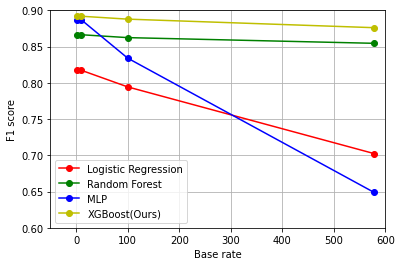

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.legend as legend
index = [1, 10, 100, 577.87]

LR=[np.mean(f1_lr_br1), np.mean(f1_lr_br10), np.mean(f1_lr_br100), np.mean(f1_lr_brreal)]
lr,=plt.plot(index, LR, 'ro-')

RF=[np.mean(f1_rf_br1), np.mean(f1_rf_br10), np.mean(f1_rf_br100),np.mean(f1_rf_brreal)]
rf,=plt.plot(index, RF, 'go-')

MLP=[np.mean(f1_mlp_br1), np.mean(f1_mlp_br10), np.mean(f1_mlp_br100), np.mean(f1_mlp_brreal)]
mlp,=plt.plot(index, MLP, 'bo-')

XGB=[np.mean(f1_xgb_br1), np.mean(f1_xgb_br10), np.mean(f1_xgb_br100), np.mean(f1_xgb_brreal)]
xgb,=plt.plot(index, XGB, 'yo-')

plt.legend([lr, rf, mlp, xgb],['Logistic Regression','Random Forest','MLP', 'XGBoost(Ours)'])
plt.xlim([-50, 600])
plt.ylim([0.6, 0.9])
plt.xlabel('Base rate')
plt.ylabel('F1 score')
plt.grid(True)
plt.show()

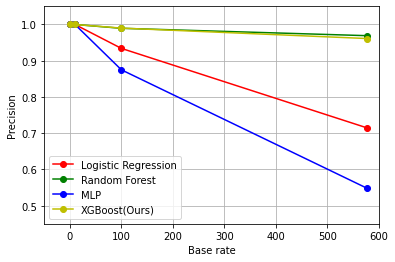

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.legend as legend
index = [1, 10, 100, 577.87]

LR=[np.mean(precision_lr_br1), np.mean(precision_lr_br10), np.mean(precision_lr_br100), np.mean(precision_lr_brreal)]
lr,=plt.plot(index, LR, 'ro-')

RF=[np.mean(precision_rf_br1), np.mean(precision_rf_br10), np.mean(precision_rf_br100),np.mean(precision_rf_brreal)]
rf,=plt.plot(index, RF, 'go-')

MLP=[np.mean(precision_mlp_br1), np.mean(precision_mlp_br10), np.mean(precision_mlp_br100), np.mean(precision_mlp_brreal)]
mlp,=plt.plot(index, MLP, 'bo-')

XGB=[np.mean(precision_xgb_br1), np.mean(precision_xgb_br10), np.mean(precision_xgb_br100), np.mean(precision_xgb_brreal)]
xgb,=plt.plot(index, XGB, 'yo-')

plt.legend([lr, rf, mlp, xgb],['Logistic Regression','Random Forest','MLP', 'XGBoost(Ours)'])
plt.xlim([-50, 600])
plt.ylim([0.45, 1.05])
plt.xlabel('Base rate')
plt.ylabel('Precision')
plt.grid(True)
plt.show()